In [17]:
# Basic Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sci-kit learn imports
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [18]:
# 1 - Load CSV file
abalone = pd.read_csv("abalone.csv")

1 b) The abalone dataset does not require any conversions as none of its features are strings.
The target that we are trying to predict is a string, but not a feature. Therefore, we do not need to convert it. 

In [19]:
# Convert dataset to numpy array and split into features/target
X = abalone.to_numpy()[:, 1:8]
y = abalone.to_numpy()[:, 0]

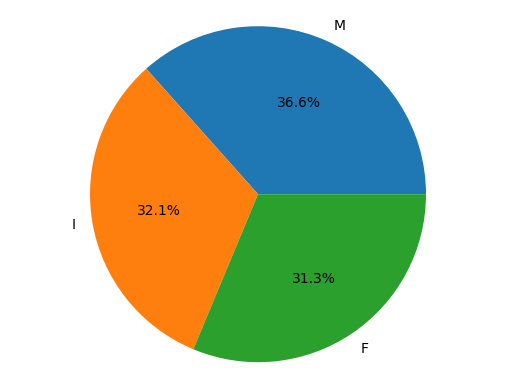

In [20]:
# 2 - Percentages of each output class
labels = 'M', 'I', 'F'
sizes = abalone['Type'].value_counts(normalize=True) * 100

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.savefig("abalone-classes")

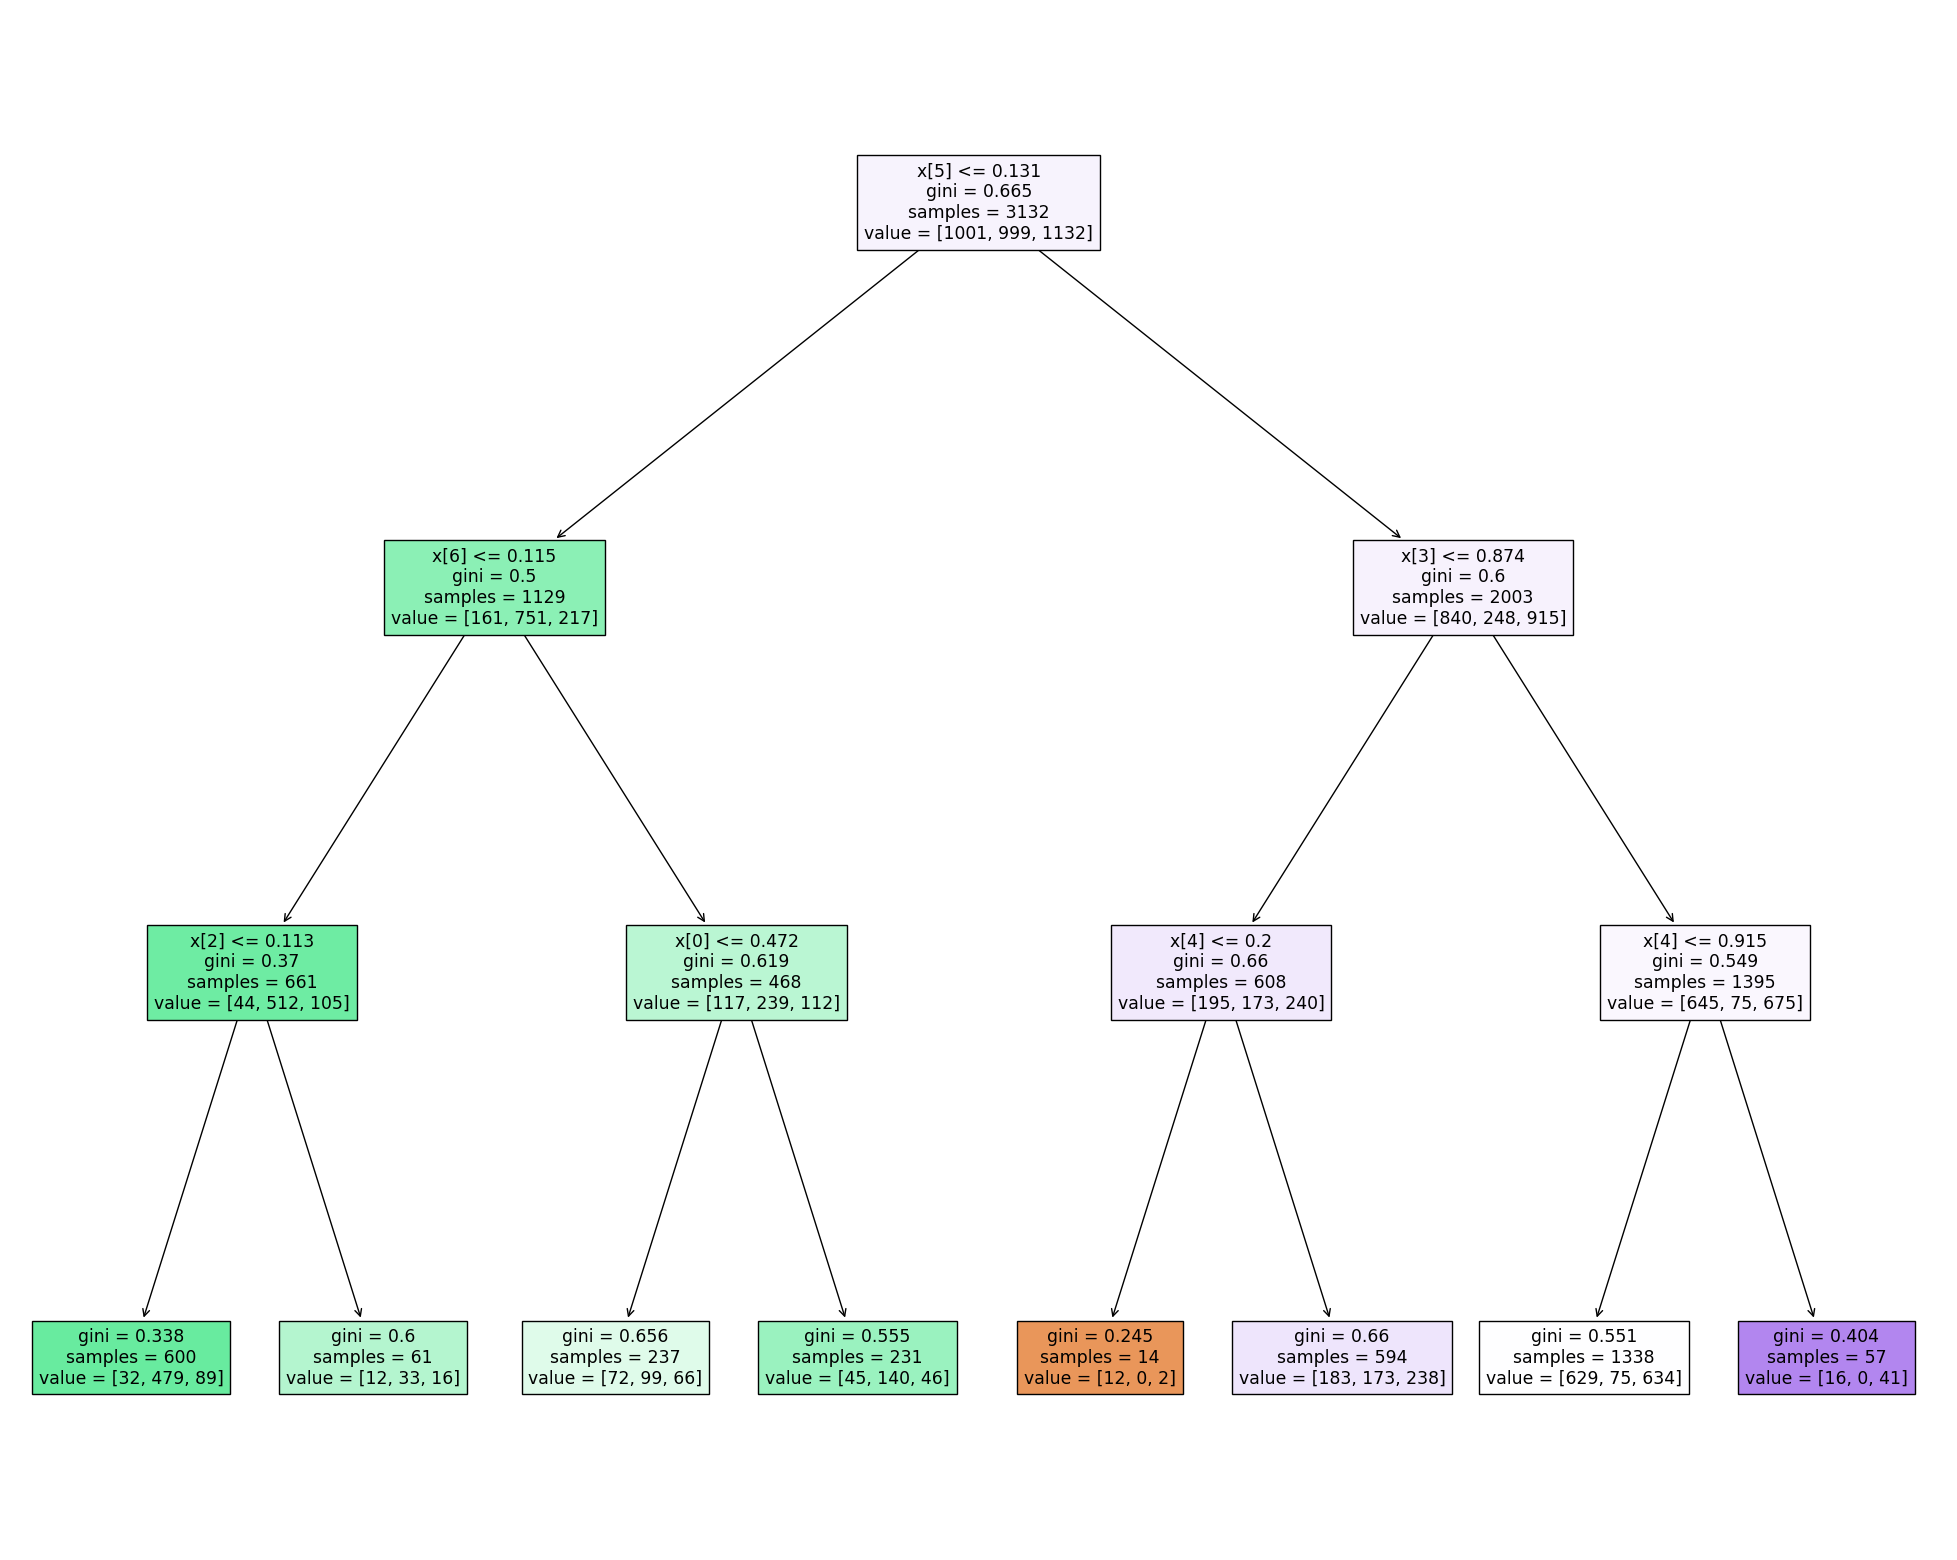

In [21]:
# 3 - Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y)

dtc = tree.DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)

# 4 a) Base DT
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dtc, filled=True)

In [22]:
# 4 b) Top DT
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,8,None], 'min_samples_split':[2,3,5]}
grid = GridSearchCV(tree.DecisionTreeClassifier(), tree_para)
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2}
0.5290449475416686


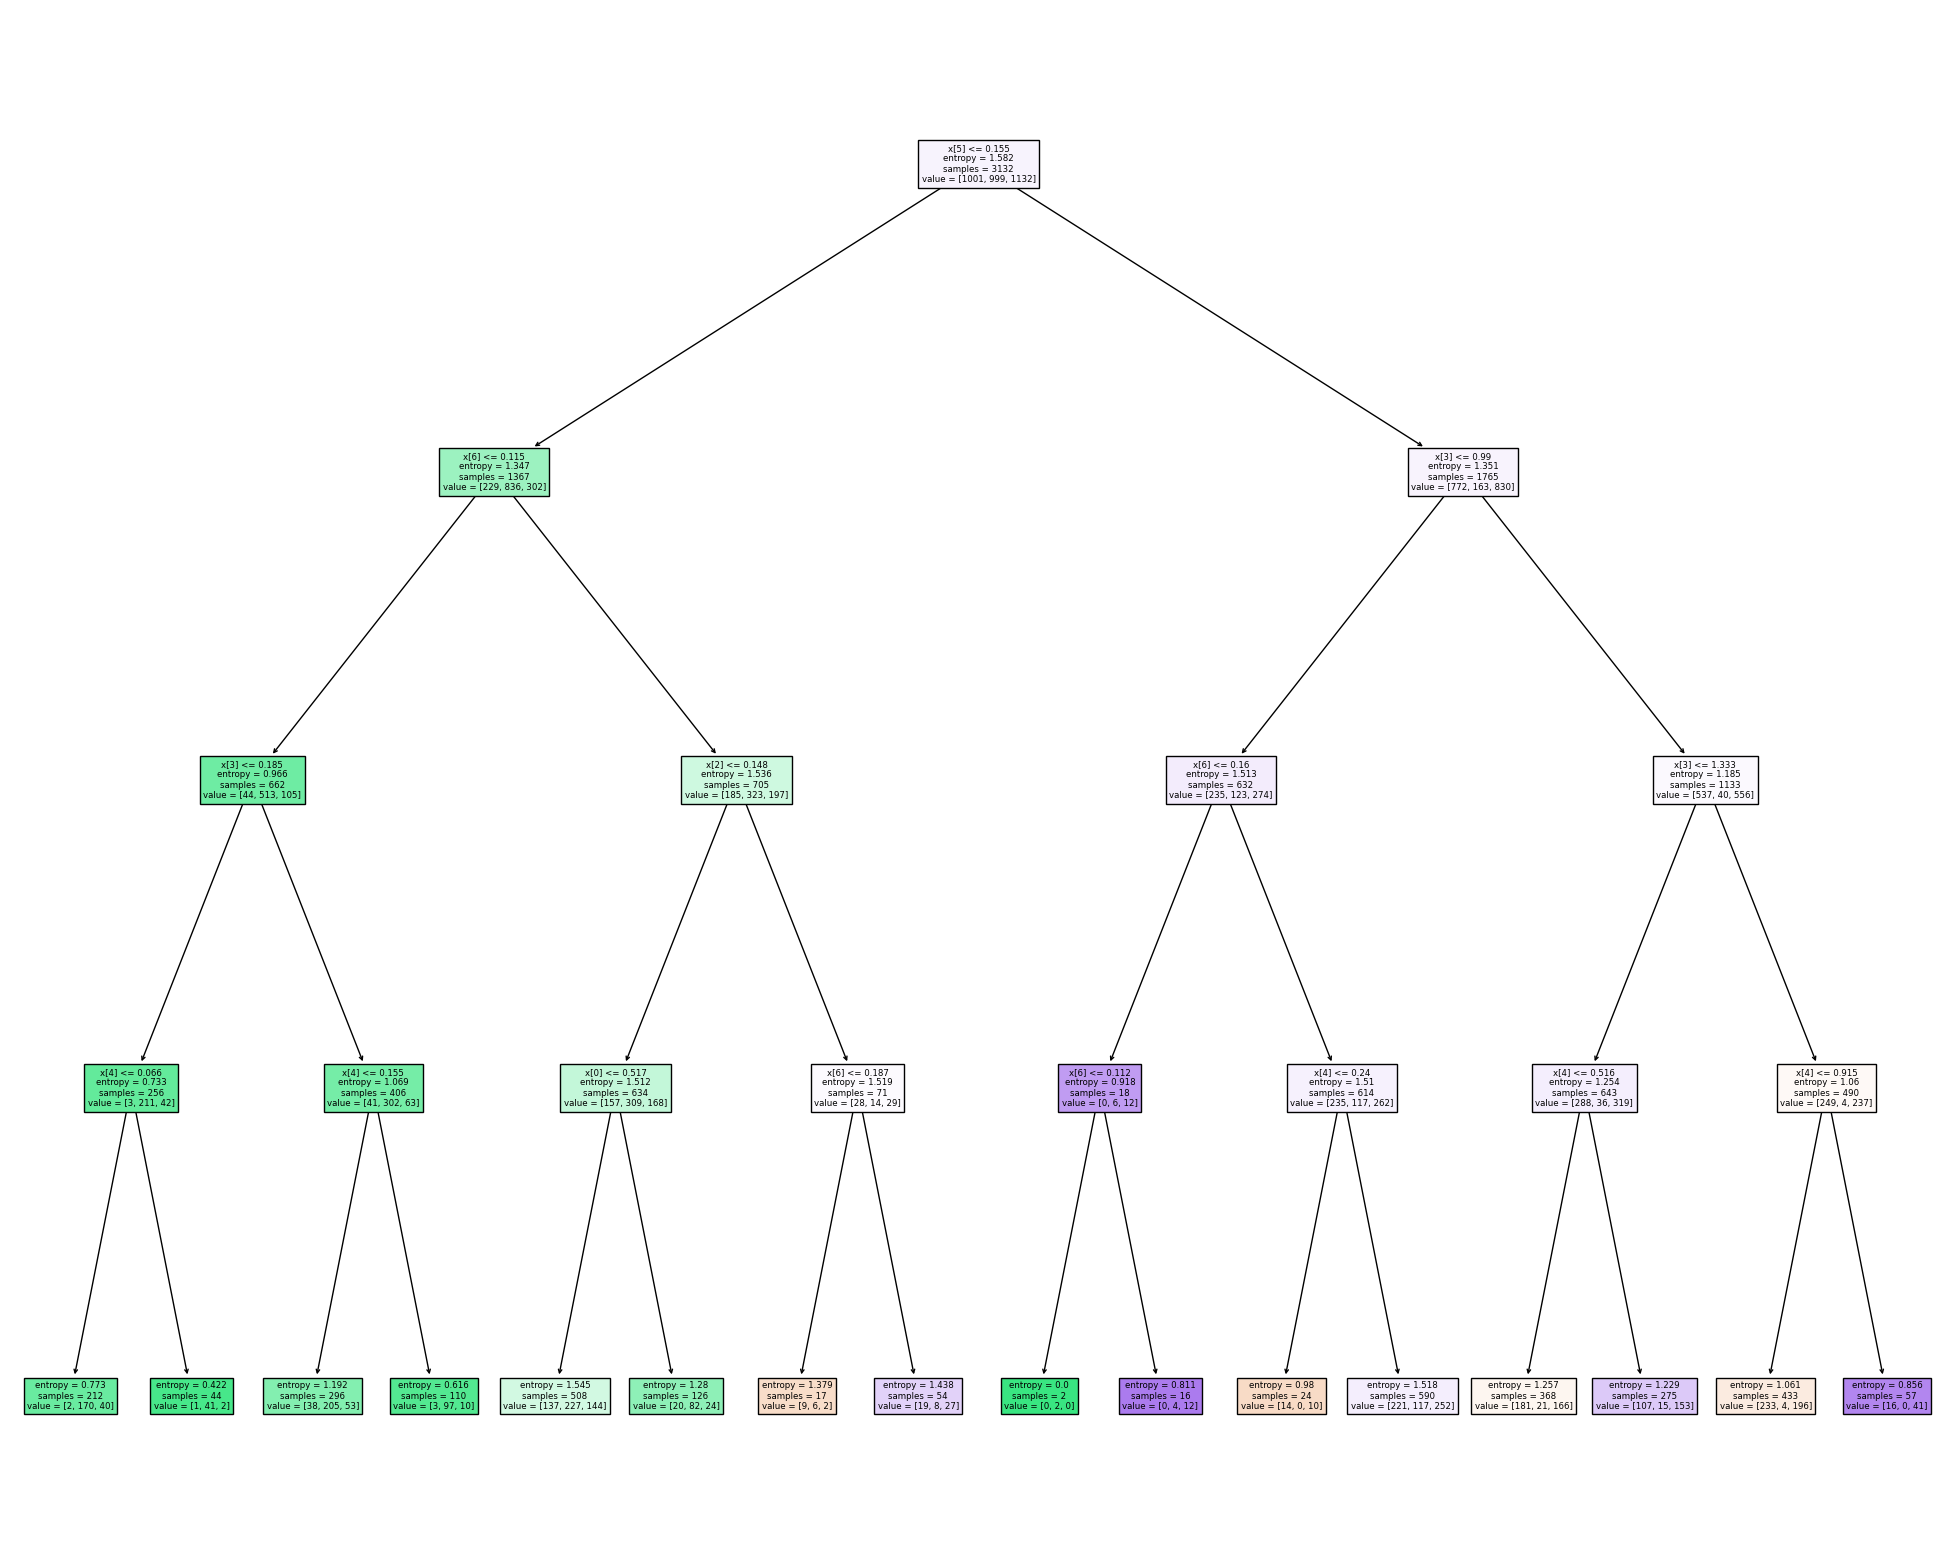

In [23]:
# Plot Top DT
top_dtc = tree.DecisionTreeClassifier()
top_dtc.set_params(**grid.best_params_)
top_dtc.fit(X_train, y_train)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(top_dtc, filled=True)

In [24]:
# 4 c) Base-MLP:

base_mlp = MLPClassifier(hidden_layer_sizes=(100,100), activation='logistic', solver='sgd')
base_mlp.fit(X_train, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100),
              solver='sgd')

In [25]:
# 4 d) Top-MLP:

# Use gridsearch to find the best combination of hyperparameters
# Note: Choosing higher hidden layer sizes can significantly increase iterations / run-time
mlp_param = {'activation': ['logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(128, 64), (10, 10, 10)], 'solver': ['adam', 'sgd']}
mlp_grid = GridSearchCV(MLPClassifier(max_iter=1000), mlp_param)
mlp_grid.fit(X_train, y_train)

# Display the best hyperparameters found by the gridsearch
mlp_best_param = mlp_grid.best_params_
print(mlp_best_param)

# Define Top MLP based on gridsearch results
top_mlp = mlp_grid.best_estimator_

{'activation': 'tanh', 'hidden_layer_sizes': (128, 64), 'solver': 'adam'}


In [26]:
# 5) Function to create confusion matrices
def plotConfusionMatrix(y_true, y_pred, classes, normalize = True, title = None, cmap = plt.cm.Blues,):
    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    #Ticks
    ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), 
           #labels
           xticklabels = classes, yticklabels = classes,
           title = title, ylabel = 'True label', xlabel = "Predicted label")
    
    #Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

    #Loop over data dimensions ad create text annotations
    fmt = '0.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha = "center", va = "center",
                    color = "white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)


In [27]:
#Open file to write to
fp = open('abalone-performance.txt', 'w')

In [28]:
# Base DT Performance

# Arrays to keep track of individual run performance scores
precisionScoresBDT = []
macroF1ScoresBDT = []
weightedF1ScoresBDT = []

# 6) Repeating the Base-DT and finding all averages and variance
for run in range(5):
    fp.write('---------------------------------------------------------------------------------------------------------------\n')
    fp.write('Base-DT with default parameters \n')
    fp.write('Run '+ str(run + 1))
    fp.write('\n \n')

    # Creating the confusion matrix for the Base-DT
    y_predBaseDT = dtc.predict(X_test)
    class_names = abalone.Type.value_counts().index
    fp.write("Confusion matrix: ")
    fp.write('\n \n')
    fp.write(str(confusion_matrix(y_test, y_predBaseDT))) # Write confusion matrix to file
    fp.write('\n \n')

    # Creating the classification report for the Base-DT
    fp.write("Classification report:")
    fp.write('\n \n')
    fp.write(classification_report(y_test, y_predBaseDT)) # Write classification report to file
    fp.write('\n')

    # Append current run's performance scores to their respective arrays
    precisionScoresBDT.append(dtc.score(X_test, y_test))
    macroF1ScoresBDT.append(f1_score(y_test, y_predBaseDT, average='macro'))
    weightedF1ScoresBDT.append(f1_score(y_test, y_predBaseDT, average='weighted'))

    dtc = tree.DecisionTreeClassifier()
    dtc.fit(X_train, y_train)


# Writing all the information to the file
fp.write("Performance Statistics: \n")
toWrite = "Average accuracy: " + str(np.mean(precisionScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the accuracy: " + str(np.var(precisionScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average macro-average F1: " + str(np.mean(macroF1ScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the macro-average F1: " + str(np.var(macroF1ScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average weighted-average F1: " + str(np.mean(weightedF1ScoresBDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the weighted-average F1: " + str(np.var(weightedF1ScoresBDT))
fp.write(toWrite)
fp.write('\n \n')


3

In [29]:
# Top DT Performance

# Arrays to keep track of individual run performance scores
precisionScoresTDT = []
macroF1ScoresTDT = []
weightedF1ScoresTDT = []

# 6) Repeating the Top-DT and finding all averages and variance
for run in range(5):
    fp.write('---------------------------------------------------------------------------------------------------------------\n')
    fp.write('Top-DT where the criterion, max_depth, and min_samples_split were changed')
    fp.write('\n')
    fp.write('Run '+ str(run + 1))
    fp.write('\n')
    fp.write('Best hyperparameters found by gridsearch: ' + str(grid.best_params_))
    fp.write('\n \n')

    # Creating the confusion matrix for the Top-DT
    y_predTopDT = top_dtc.predict(X_test)
    class_names = abalone.Type.value_counts().index
    fp.write("Confusion matrix: ")
    fp.write('\n \n')
    fp.write(str(confusion_matrix(y_test, y_predTopDT))) # Write confusion matrix to file
    fp.write('\n \n')

    # Creating the classification report for the Top-DT
    fp.write("Classification report:")
    fp.write('\n \n')
    fp.write(classification_report(y_test, y_predTopDT)) # Write classification report to file
    fp.write('\n \n')

    # Append current run's performance scores to their respective arrays
    precisionScoresTDT.append(top_dtc.score(X_test, y_test))
    macroF1ScoresTDT.append(f1_score(y_test, y_predTopDT, average='macro'))
    weightedF1ScoresTDT.append(f1_score(y_test, y_predTopDT, average='weighted'))

    tree_para = {'criterion':['gini','entropy'],'max_depth':[3,7,None], 'min_samples_split':[2,3,5]}
    grid = GridSearchCV(tree.DecisionTreeClassifier(), tree_para)
    grid.fit(X_train,y_train)
    top_dtc = tree.DecisionTreeClassifier()
    top_dtc.set_params(**grid.best_params_)
    top_dtc.fit(X_train, y_train)

# Writing all the information to the file
fp.write("Performance Statistics: \n")
toWrite = "Average accuracy: " + str(np.mean(precisionScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the accuracy: " + str(np.var(precisionScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average macro-average F1: " + str(np.mean(macroF1ScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the macro-average F1: " + str(np.var(macroF1ScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average weighted-average F1: " + str(np.mean(weightedF1ScoresTDT))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the weighted-average F1: " + str(np.var(weightedF1ScoresTDT))
fp.write(toWrite)
fp.write('\n \n')


3

In [30]:
# Base MLP Performance

# Arrays to keep track of individual run performance scores
precisionScoresBMLP = []
macroF1ScoresBMLP = []
weightedF1ScoresBMLP = []

# 6) Repeating the Base-MLP and finding all averages and variance
for run in range(5):
    fp.write('--------------------------------------------------------------------------------------------------------------- \n')
    fp.write('Base-MLP with default parameters \n')
    fp.write('Run '+ str(run + 1))
    fp.write('\n \n')

    # Creating the confusion matrix for the Base-MLP
    y_predBaseMLP = base_mlp.predict(X_test)
    class_names = abalone.Type.value_counts().index
    fp.write("Confusion matrix: ")
    fp.write('\n \n')
    fp.write(str(confusion_matrix(y_test, y_predBaseMLP))) # Write confusion matrix to file
    fp.write('\n \n')

    # Creating the classification report for the Base-MLP
    fp.write("Classification report:")
    fp.write('\n \n')
    fp.write(classification_report(y_test, y_predBaseMLP, zero_division=0)) # Write classification report to file
    fp.write('\n')

    # Append current run's performance scores to their respective arrays
    precisionScoresBMLP.append(base_mlp.score(X_test, y_test))
    macroF1ScoresBMLP.append(f1_score(y_test, y_predBaseMLP, average='macro'))
    weightedF1ScoresBMLP.append(f1_score(y_test, y_predBaseMLP, average='weighted'))

    base_mlp = MLPClassifier(hidden_layer_sizes=(100, 100), activation='logistic', solver='sgd')
    base_mlp.fit(X_train, y_train)

# Writing all the information to the file
fp.write("Performance Statistics: \n")
toWrite = "Average accuracy: " + str(np.mean(precisionScoresBMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the accuracy: " + str(np.var(precisionScoresBMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average macro-average F1: " + str(np.mean(macroF1ScoresBMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the macro-average F1: " + str(np.var(macroF1ScoresBMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average weighted-average F1: " + str(np.mean(weightedF1ScoresBMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the weighted-average F1: " + str(np.var(weightedF1ScoresBMLP))
fp.write(toWrite)
fp.write('\n \n')

3

In [31]:
# Top MLP Performance


# Uncomment to tst during the demo
''' 
# Plotting confusion matrix for the Top-MLP
fp.write('---------------------------------------------------------------------------------------------------------------')
fp.write('\n \n')
fp.write('Top-MLP where the criterion, max_depth, and min_samples_split were changed')
fp.write('\n')
fp.write('Best hyperparameters found by gridsearch: ' + str(grid.best_params_))
fp.write('\n \n')

y_predTopMLP = top_mlp.predict(X_test)
class_names = abalone.Type.value_counts().index
plotConfusionMatrix(y_test, y_predTopMLP, classes=class_names, normalize = False, title = "Top-MLP Confusion Matrix")
fp.write("Confusion matrix: ")
fp.write('\n \n')
fp.write(str(confusion_matrix(y_test, y_predTopMLP)))
fp.write('\n \n')

# Creating the classification report for the Top-MLP
print(classification_report(y_test, y_predTopMLP, zero_division=0))
fp.write("Classification report:")
fp.write('\n \n')
fp.write(classification_report(y_test, y_predTopMLP, zero_division=0))
fp.write('\n \n')
'''

# Arrays to keep track of individual run performance scores
precisionScoresTMLP = []
macroF1ScoresTMLP = []
weightedF1ScoresTMLP = []

# 6) Repeating the Top-MLP and finding all averages and variance
for run in range(5):
    fp.write('---------------------------------------------------------------------------------------------------------------\n')
    fp.write('Top-MLP where the criterion, max_depth, and min_samples_split were changed')
    fp.write('\n')
    fp.write('Run '+ str(run + 1))
    fp.write('\n')
    fp.write('Best hyperparameters found by gridsearch: ' + str(grid.best_params_))
    fp.write('\n \n')

    # Plotting confusion matrix for the Top-MLP
    y_predTopMLP = top_mlp.predict(X_test)
    class_names = abalone.Type.value_counts().index
    fp.write("Confusion matrix: ")
    fp.write('\n \n')
    fp.write(str(confusion_matrix(y_test, y_predTopMLP))) # Write confusion matrix to file
    fp.write('\n \n')

    # Creating the classification report for the Top-MLP
    fp.write("Classification report:")
    fp.write('\n \n')
    fp.write(classification_report(y_test, y_predTopMLP, zero_division=0)) # Write classification report to file
    fp.write('\n \n')

    # Append current run's performance scores to their respective arrays
    precisionScoresTMLP.append(top_mlp.score(X_test, y_test))
    macroF1ScoresTMLP.append(f1_score(y_test, y_predTopMLP, average='macro'))
    weightedF1ScoresTMLP.append(f1_score(y_test, y_predTopMLP, average='weighted'))

    tree_para = {'activation': ['logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(128, 64), (10, 10, 10)], 'solver': ['adam', 'sgd']}
    grid = GridSearchCV(MLPClassifier(max_iter=2000), mlp_param)
    grid.fit(X_train,y_train)
    top_mlp = grid.best_estimator_
    top_mlp.fit(X_train, y_train)

# Writing all the information to the file
fp.write("Performance Statistics: \n")
toWrite = "Average accuracy: " + str(np.mean(precisionScoresTMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the accuracy: " + str(np.var(precisionScoresTMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average macro-average F1: " + str(np.mean(macroF1ScoresTMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the macro-average F1: " + str(np.var(macroF1ScoresTMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Average weighted-average F1: " + str(np.mean(weightedF1ScoresTMLP))
fp.write(toWrite)
fp.write('\n')
toWrite = "Variance of the weighted-average F1: " + str(np.var(weightedF1ScoresTDT))
fp.write(toWrite)
fp.write('\n \n')


3

In [32]:
# Closing the text file
fp.close()